# Neuronales Netz

### Daten laden

In [49]:
import pandas as pd

csv_file = "../data/data_selected_v1.csv"

df = pd.read_csv(csv_file)
df.columns

Index(['Unnamed: 0', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments',
       'Stream', 'Genre', 'Artist_encoded', 'Album_type_encoded',
       'Licensed_encoded', 'official_video_encoded'],
      dtype='object')

In [50]:
import tensorflow as tf
# Manuell auf CPU einschränken
tf.config.set_visible_devices([], "GPU")

### Genres für das Training auswählen

In [51]:
genres_to_keep = ["classic", "metal", "rock", "hip hop", "electronic", "pop"]
df = df[df['Genre'].isin(genres_to_keep)]

Genre
hip hop       2361
rock          1418
pop           1391
electronic     677
metal          430
classic        169
Name: count, dtype: int64
Anzahl an Songs: 6446


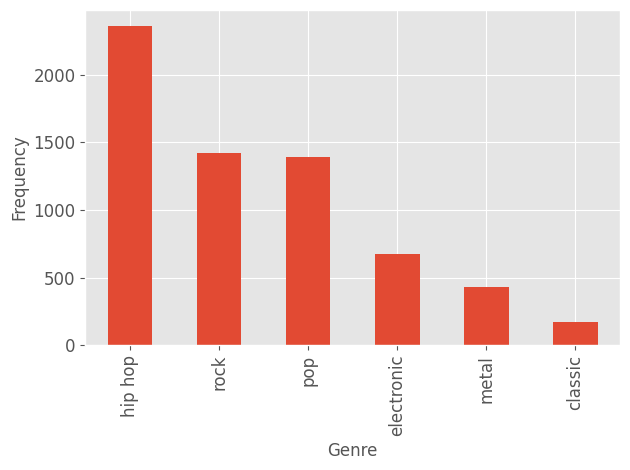

In [52]:
import matplotlib.pyplot as plt

plt.figure()
# Anzahl der Einträge pro Genre
genre_counts = df['Genre'].value_counts()
print(genre_counts)
# Histogramm erstellen
#plt.figure(figsize=(8, 6))
genre_counts.plot(kind='bar')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('Genre', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
#plt.title('bar chart of class imbalance')
plt.tight_layout()
plt.savefig('../figures/genre_hist.pdf')
print(f"Anzahl an Songs: {df.shape[0]}")

Genre
hip hop       2361
rock          1418
pop           1391
electronic     677
metal          430
classic        169
Name: count, dtype: int64
Anzahl an Songs: 6446


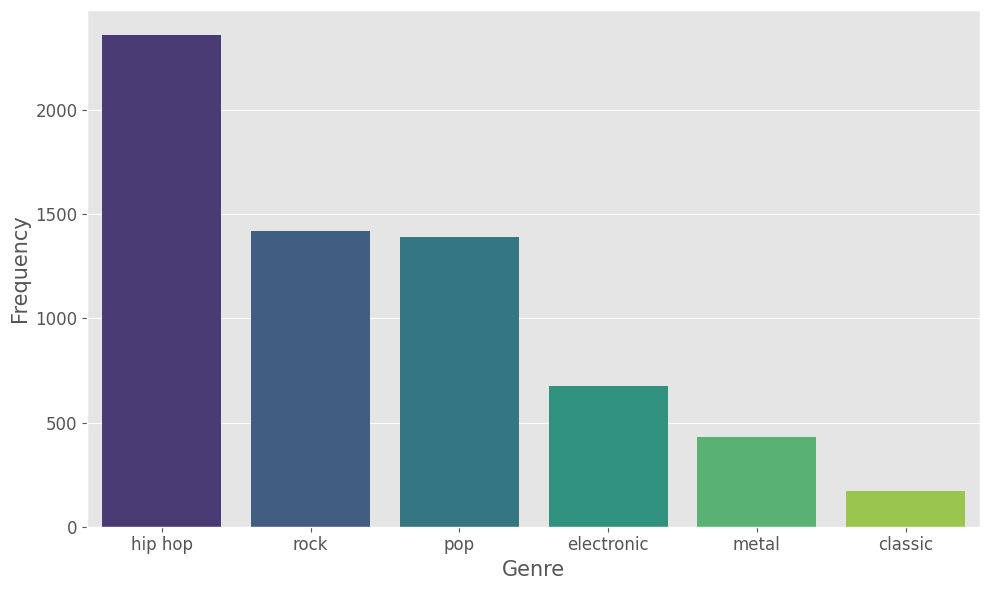

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setzen Sie den Stil auf "ggplot" für ein ansprechenderes Aussehen
plt.style.use('ggplot')

# Anzahl der Einträge pro Genre
genre_counts = df['Genre'].value_counts()
print(genre_counts)

# Histogramm erstellen
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('Genre', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

plt.tight_layout()
plt.savefig('../figures/nn/genre_hist2.pdf')
print(f"Anzahl an Songs: {df.shape[0]}")


### Designmatrix und Target erstellen

In [54]:
features_drop = ['Genre', 'Unnamed: 0']

X = df.drop(features_drop, axis=1)
Y = df['Genre']

In [55]:
# One-Hot-Encoding durchführen
Y = pd.get_dummies(Y)
num_classes = len(Y.value_counts())

# label um One-Hot-Encoding hinterher wieder zu übersetzen
genre_mapping = Y.columns
label = []
for index, genre in enumerate(genre_mapping):
    label.append(genre)
    print("Genre", index, ":", genre)

Genre 0 : classic
Genre 1 : electronic
Genre 2 : hip hop
Genre 3 : metal
Genre 4 : pop
Genre 5 : rock


### Split in Train, Validation und Test 

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.3, stratify=Y_train, random_state=42)

### Transformation und Skalierung der Features

In [57]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
# Fit NUR auf train...
transformer = QuantileTransformer(output_distribution="normal")
transformer.fit(X_train)

# ... dann transform auf alle
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

# Werte der Attribute mit MinMax auf [-1,1] skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
# Fit wieder auf train...
scaler.fit(X_train)

# ... dann wieder transform
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Modell

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_model_from_params(params):
    num_hidden_layers = params['num_hidden_layers']
    activation_function = params['activation']
    dropout_rate = params['dropout']
    units_per_layer = [params['neurons_1'],params['neurons_2'],params['neurons_3'],params['neurons_4']]

    model = Sequential()
    model.add(Dense(units=units_per_layer[0], activation=activation_function, input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))

    for i in range(1, num_hidden_layers+1):
        if i < len(units_per_layer):
            model.add(Dense(units=units_per_layer[i], activation=activation_function))
            model.add(Dropout(dropout_rate))

    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    
    return model


### Hyperparameter laden

In [59]:
import pandas as pd
resultsDF = pd.read_csv('../HPO-data/HPO_combined.csv')
resultsDF.head()

,activation,activation_numerical,batch_size,delta_acc,dropout,early_stopping_patience,epochs,mean_train_score,mean_val_score,neurons_1,...,neurons_4,num_hidden_layers,optimizer,optimizer_numerical,reduce_lr_factor,reduce_lr_min_lr,reduce_lr_patience,std_train_score,std_val_score,weight_contraint
0,relu,0,64,0.105024,0.2,15,60,0.734723,0.664893,128,...,1024,2,adam,0.0,0.1,1.000000e-07,5,0.004310,0.013605,10.0
1,relu,0,64,0.057413,0.2,15,60,0.696655,0.658829,128,...,1024,2,nadam,1.0,0.1,1.000000e-07,5,0.027048,0.008308,10.0
2,relu,0,64,0.099673,0.2,20,60,0.726362,0.660525,128,...,1024,2,adam,0.0,0.1,1.000000e-07,5,0.022240,0.004077,10.0
3,relu,0,64,0.101587,0.2,20,60,0.724422,0.657617,128,...,1024,2,nadam,1.0,0.1,1.000000e-07,5,0.027498,0.008000,10.0
4,relu,0,128,0.085200,0.2,15,60,0.716540,0.660283,128,...,1024,2,adam,0.0,0.1,1.000000e-07,5,0.018764,0.006314,10.0


### graphische Darstellung der Performanceänderung

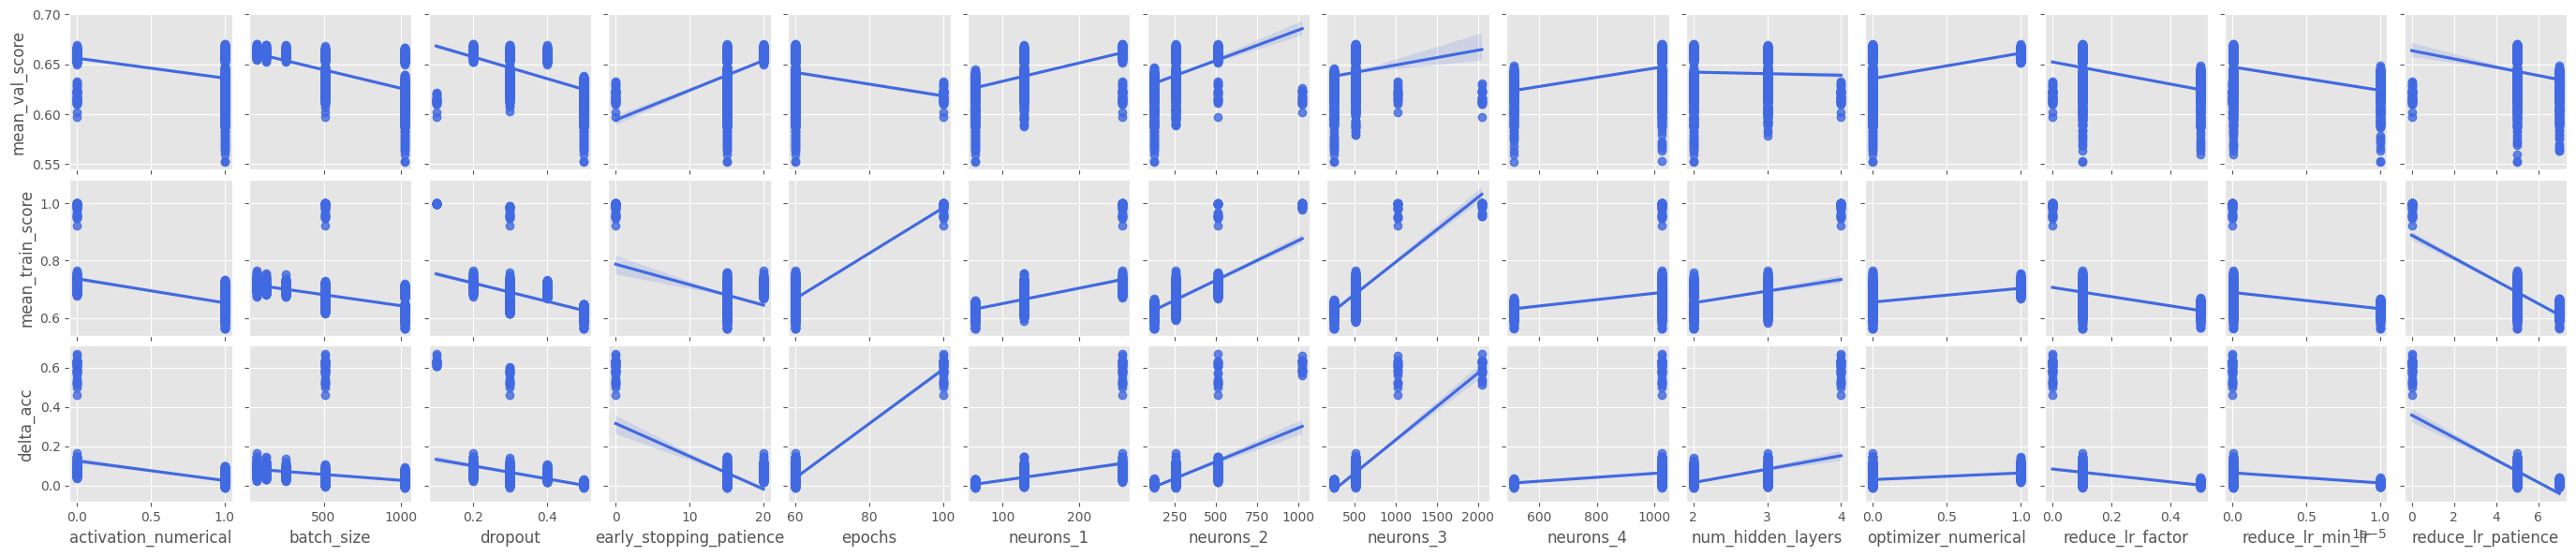

In [60]:
import seaborn as sns

# Mapping der activation_function auf numerische Werte

x_vars = [ 
    'activation_numerical', 
    'batch_size', 
    'dropout', 
    'early_stopping_patience', 
    'epochs', 
    'neurons_1', 
    'neurons_2', 
    'neurons_3', 
    'neurons_4', 
    'num_hidden_layers', 
    'optimizer_numerical', 
    'reduce_lr_factor', 
    'reduce_lr_min_lr', 
    'reduce_lr_patience', 
#    'weight_contraint'
]

y_vars = [
    'mean_val_score',
    'mean_train_score',
    'delta_acc'
]

sns.pairplot(resultsDF, x_vars=x_vars, y_vars=y_vars, kind='reg', height=2, plot_kws={'color':'royalblue'})
plt.savefig('../figures/nn/HPO_parameter.pdf', format='pdf')

### Auswählen der besten Hyperparameter-Kombination

In [61]:
def calculate_score(row):
    # Bestmöglicher Score ist 
    best_score = 1.0
    
    # Berechnung des Scores basierend auf Delta-Accuracy und Best Validation Accuracy
    delta_acc_score = 1.0 - abs(row['delta_acc'])  # Je kleiner das Delta, desto besser der Score
    best_val_acc_score = row['mean_val_score']  # Je größer die Best Validation Accuracy, desto besser der Score
    
    #Gewichte
    w1=0.4
    w2=1
    
    # Gesamtscore berechnen
    score = (w1 * delta_acc_score + w2 * best_val_acc_score) / 2
    
    # Normalisierung des Scores auf den Bereich [0, 1]
    normalized_score = score / best_score
    
    return normalized_score

# Score-Spalte hinzufügen
resultsDF['score'] = resultsDF.apply(calculate_score, axis=1)
resultsDF = resultsDF.sort_values('score', ascending=False)
resultsDF.head()

,activation,activation_numerical,batch_size,delta_acc,dropout,early_stopping_patience,epochs,mean_train_score,mean_val_score,neurons_1,...,num_hidden_layers,optimizer,optimizer_numerical,reduce_lr_factor,reduce_lr_min_lr,reduce_lr_patience,std_train_score,std_val_score,weight_contraint,score
475,LeakyReLU,1,512,0.028424,0.4,20,60,0.684288,0.665375,256,...,2,nadam,1.0,0.1,1.000000e-07,5,0.004174,0.005336,10.0,0.527003
102,LeakyReLU,1,64,0.020702,0.4,20,60,0.675437,0.661738,128,...,2,adam,0.0,0.1,1.000000e-07,5,0.012839,0.007111,10.0,0.526729
277,LeakyReLU,1,1024,0.027209,0.2,15,60,0.681985,0.663920,256,...,2,nadam,1.0,0.1,1.000000e-07,5,0.021427,0.006155,10.0,0.526518
232,LeakyReLU,1,512,0.017276,0.4,15,60,0.670951,0.659557,128,...,2,adam,0.0,0.1,1.000000e-07,5,0.013015,0.008137,10.0,0.526323
106,LeakyReLU,1,128,0.031748,0.4,20,60,0.685500,0.664406,128,...,2,adam,0.0,0.1,1.000000e-07,5,0.001582,0.007314,10.0,0.525853


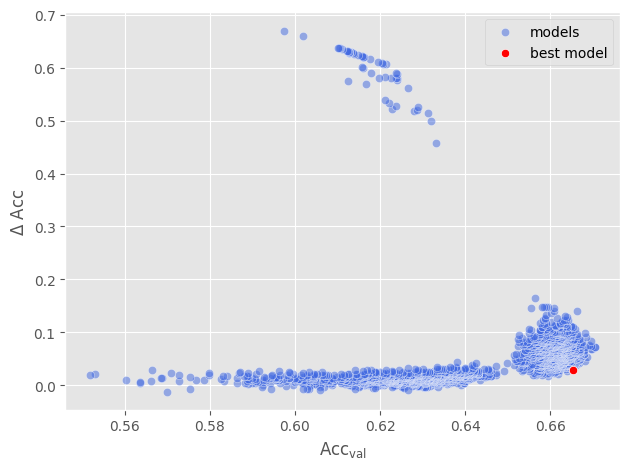

In [62]:
import matplotlib.pyplot as plt

best_params = resultsDF.head(1)

# Scatterplot erstellen
sns.scatterplot(data=resultsDF, x='mean_val_score', y='delta_acc', alpha=0.5, color='royalblue', label='models')
sns.scatterplot(data=best_params, x='mean_val_score', y='delta_acc', color='red', label='best model')

# Achsentitel hinzufügen
plt.xlabel('Acc$_\mathrm{val}$', fontsize=12)
plt.ylabel('$\Delta$ Acc', fontsize=12)

plt.tight_layout()

# Plot anzeigen
plt.savefig('../figures/nn/HPO_scatter.pdf')

In [63]:
best_params = resultsDF.iloc[0]
best_params

activation                 LeakyReLU
activation_numerical               1
batch_size                       512
delta_acc                   0.028424
dropout                          0.4
early_stopping_patience           20
epochs                            60
mean_train_score            0.684288
mean_val_score              0.665375
neurons_1                        256
neurons_2                        512
neurons_3                        512
neurons_4                       1024
num_hidden_layers                  2
optimizer                      nadam
optimizer_numerical              1.0
reduce_lr_factor                 0.1
reduce_lr_min_lr                 0.0
reduce_lr_patience                 5
std_train_score             0.004174
std_val_score               0.005336
weight_contraint                10.0
score                       0.527003
Name: 475, dtype: object

In [64]:
model = build_model_from_params(best_params)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               5120      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                

### Das beste Modell

In [65]:
batch_size = best_params['batch_size']
#nb_epoch = best_params['epochs']
nb_epoch=80

# Definiere die Early Stopping-Bedingungen
early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['early_stopping_patience'], mode='min', restore_best_weights=True)

# Definiere die Reduzierung der Lernrate, falls die Verbesserung stagniert
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=best_params['reduce_lr_factor'], best_patience=best_params['reduce_lr_patience'], mode='min', min_lr=best_params['reduce_lr_min_lr'])

hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr], verbose=0)

In [66]:
Y_pred = model.predict(X_test)

61/61 [==============================] - 0s 5ms/step


### Evaluation

In [67]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs',fontsize=12)
    plt.ylabel('Loss',fontsize=12)
    plt.plot(network_history.history['loss'], color='royalblue')
    plt.plot(network_history.history['val_loss'], color='red')
    plt.legend(['Training', 'Validation'])
    plt.tight_layout()
    plt.savefig('../figures/nn/Loss.pdf')
    
    plt.figure()
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.plot(network_history.history['accuracy'], color='royalblue')
    plt.plot(network_history.history['val_accuracy'], color='red')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.tight_layout()
    plt.savefig('../figures/nn/Acc.pdf')

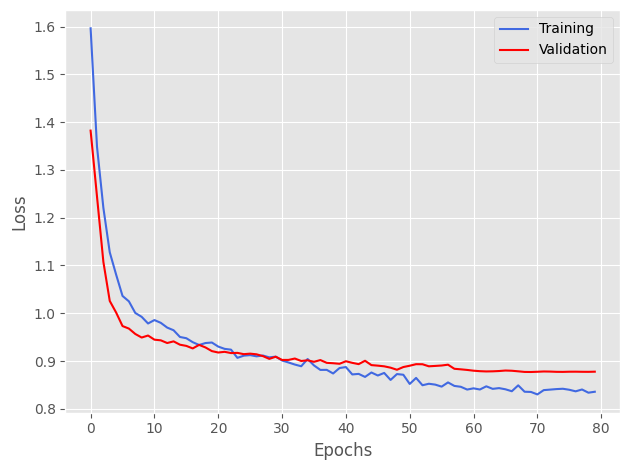

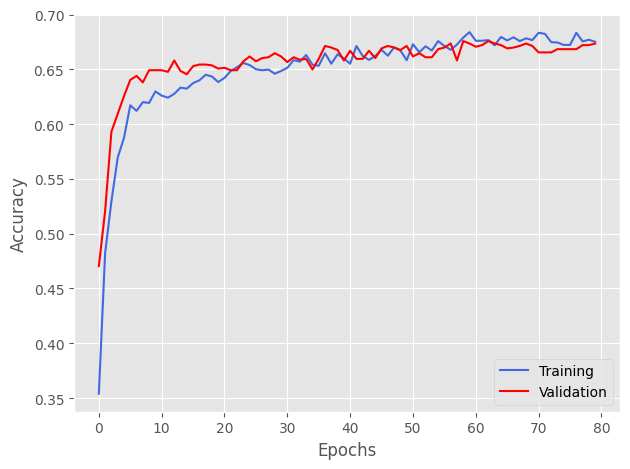

In [68]:
plot_history(hist)

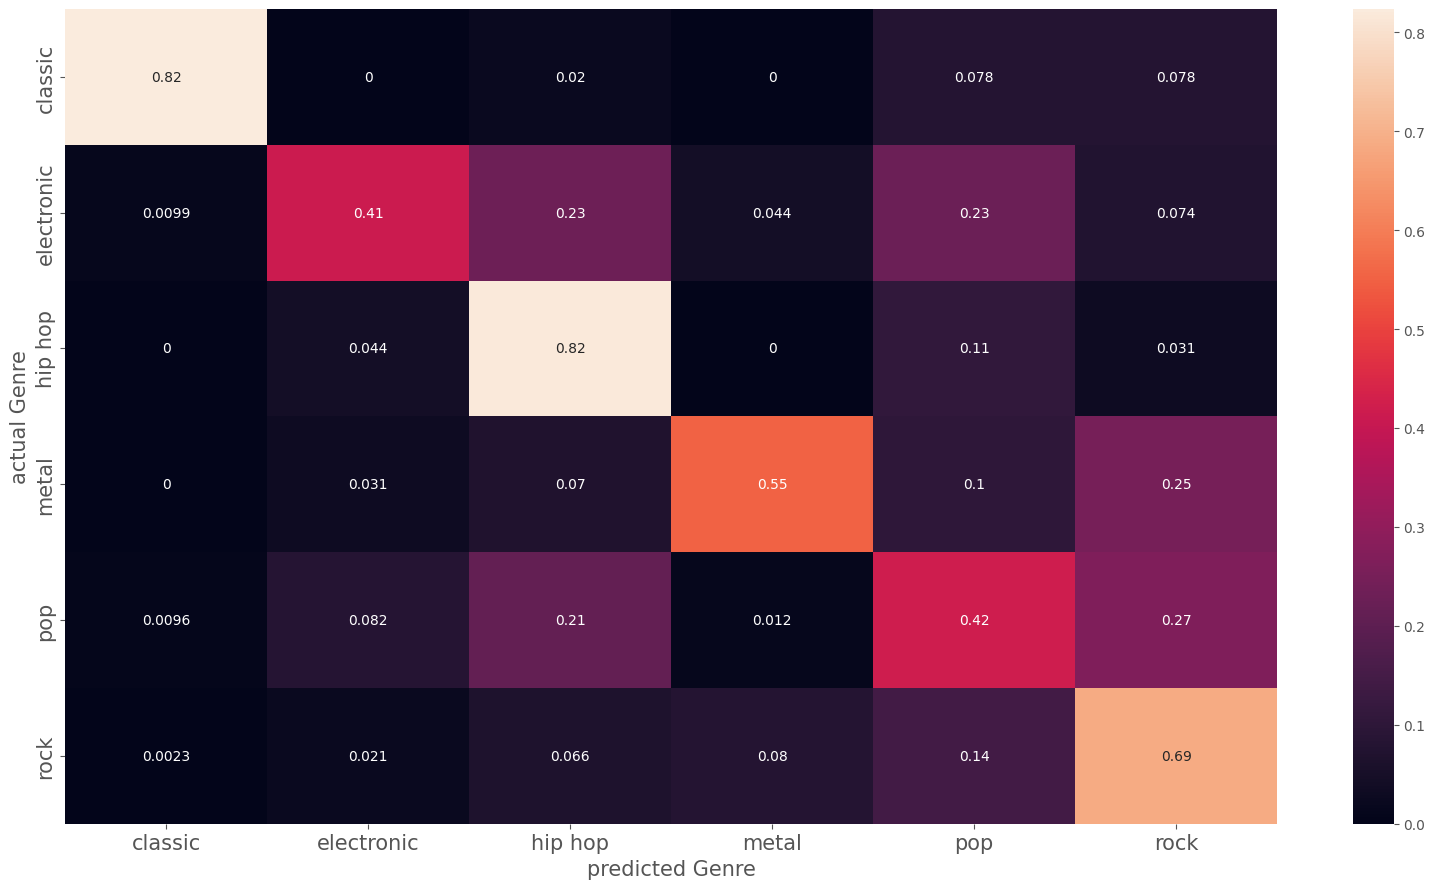

In [69]:
from sklearn.metrics import confusion_matrix

Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_classes, Y_pred_classes, normalize='true')
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label)
plt.xlabel('predicted Genre', fontsize=15)
plt.ylabel('actual Genre', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../figures/nn/confusion_matrix_nn.png')
plt.show()

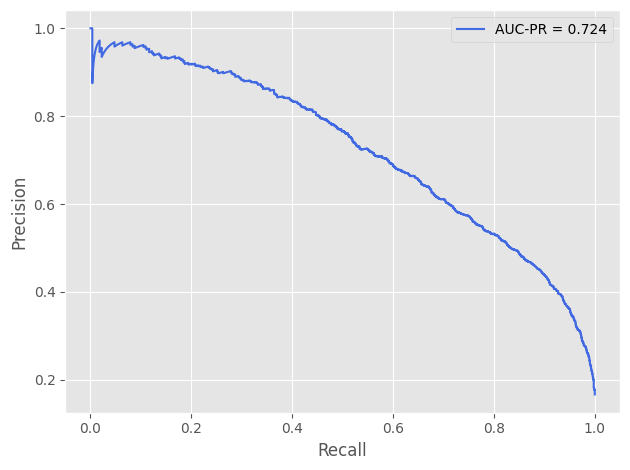

In [70]:
from sklearn.metrics import precision_recall_curve, auc

if isinstance(Y_test, pd.DataFrame):
    Y_test = Y_test.values
if isinstance(Y_pred, pd.DataFrame):
    Y_pred = Y_pred.values

precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_pred.ravel())


# Berechne Precision, Recall und Schwellenwerte
precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_pred.ravel())

# Berechne den AUC-PR
auc_pr = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3}", color='royalblue')
plt.xlabel('Recall',fontsize=12)
plt.ylabel('Precision',fontsize=12)
plt.legend()
plt.tight_layout()
#plt.title('Precision-Recall Curve')
plt.savefig('../figures/PR_curve.pdf')

hip hop: AUC-PR = 0.873
classic: AUC-PR = 0.842
rock: AUC-PR = 0.693
metal: AUC-PR = 0.591
pop: AUC-PR = 0.488
electronic: AUC-PR = 0.461


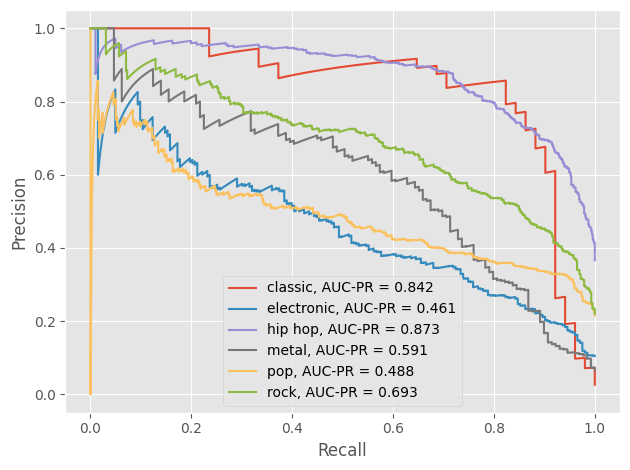

In [71]:
# Precision Recall Curve für jede Klasse einzeln

n_classes = Y_test.shape[1]

if isinstance(Y_test, np.ndarray):
    Y_test = pd.DataFrame(Y_test)
if isinstance(Y_pred, np.ndarray):
    Y_pred = pd.DataFrame(Y_pred)

auc_pr_values = []

# Für jede Klasse
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(Y_test.iloc[:, i], Y_pred.iloc[:, i])

    # Berechne den AUC-PR
    auc_pr = auc(recall, precision)
    auc_pr_values.append((label[i], auc_pr))

    plt.plot(
        recall,
        precision,
        label=f"{label[i]}, AUC-PR = {auc_pr:.3}",
    )

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend()
plt.tight_layout()
#plt.title("Precision-Recall Curve")
plt.savefig('../figures/nn/PR_curve_genres.pdf')

# Genres nach AUC-PR-Wert sortieren
auc_pr_values_sorted = sorted(auc_pr_values, key=lambda x: x[1], reverse=True)

# Ausgabe der Genres und AUC-PR-Werte
for genre, auc_pr in auc_pr_values_sorted:
    print(f"{genre}: AUC-PR = {auc_pr:.3}")

In [72]:
Y_pred = model.predict(X_test)

# Konvertiere die Vorhersagen in diskrete Klassen
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Konvertiere die Ground-Truth-Labels in diskrete Klassen
Y_test_classes = np.argmax(Y_test, axis=1)

# Berechne die Accuracy
accuracy = np.mean(Y_pred_classes == Y_test_classes)
print("Accuracy:", accuracy)


61/61 [==============================] - 0s 6ms/step
Accuracy: 0.6432264736297828


In [73]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        51
           1       0.52      0.41      0.46       203
           2       0.77      0.82      0.79       708
           3       0.60      0.55      0.57       129
           4       0.47      0.42      0.44       417
           5       0.61      0.69      0.65       426

    accuracy                           0.64      1934
   macro avg       0.64      0.62      0.63      1934
weighted avg       0.63      0.64      0.64      1934



# Alternativmethoden

In [74]:
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("../data/data_selected_v1.csv", index_col=0)

genres_to_keep = ["classic", "metal", "rock", "hip hop", "electronic", "pop"]
df = df[df["Genre"].isin(genres_to_keep)]

# Aufteilen
X = df.drop("Genre", axis=1)
y = df["Genre"]

# Genre Kodieren
genre_encoder = LabelEncoder()
one_hot_y = genre_encoder.fit_transform(y)

# Trainings- und Testsatz
X_train, X_test, y_train, y_test = train_test_split(
    X, one_hot_y, test_size=0.2, stratify=one_hot_y, random_state=42
)

# Validierungssatz
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

features_to_use = [
    "Danceability",
    "Energy",
    "Key",
    "Loudness",
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
    "Valence",
    "Tempo",
    "Duration_ms",
    "Views",
    "Likes",
    "Comments",
    "Stream",
    # "Artist_encoded", # Die hier machen Probleme
    # "Album_type_encoded",
    # "Licensed_encoded",
    # "official_video_encoded",
]
X_train = X_train[features_to_use]
X_test = X_test[features_to_use]
X_val = X_val[features_to_use]

# Erstmal Transformieren (TODO Ausprobieren, welche Trafo hier die besten Ergebnisse liefert)
# Fit NUR auf train...
transformer = QuantileTransformer(output_distribution="normal")
transformer.fit(X_train)

# ... dann transform auf alle
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

# Werte der Attribute mit MinMax auf [-1,1] skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
# Fit wieder auf train...
scaler.fit(X_train)

# ... dann wieder transform
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## SVMs

In [75]:
from sklearn import svm
clf = svm.SVC(kernel="rbf", probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [76]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy on test set is {accuracy*100:.2f}%")

Model accuracy on test set is 63.88%


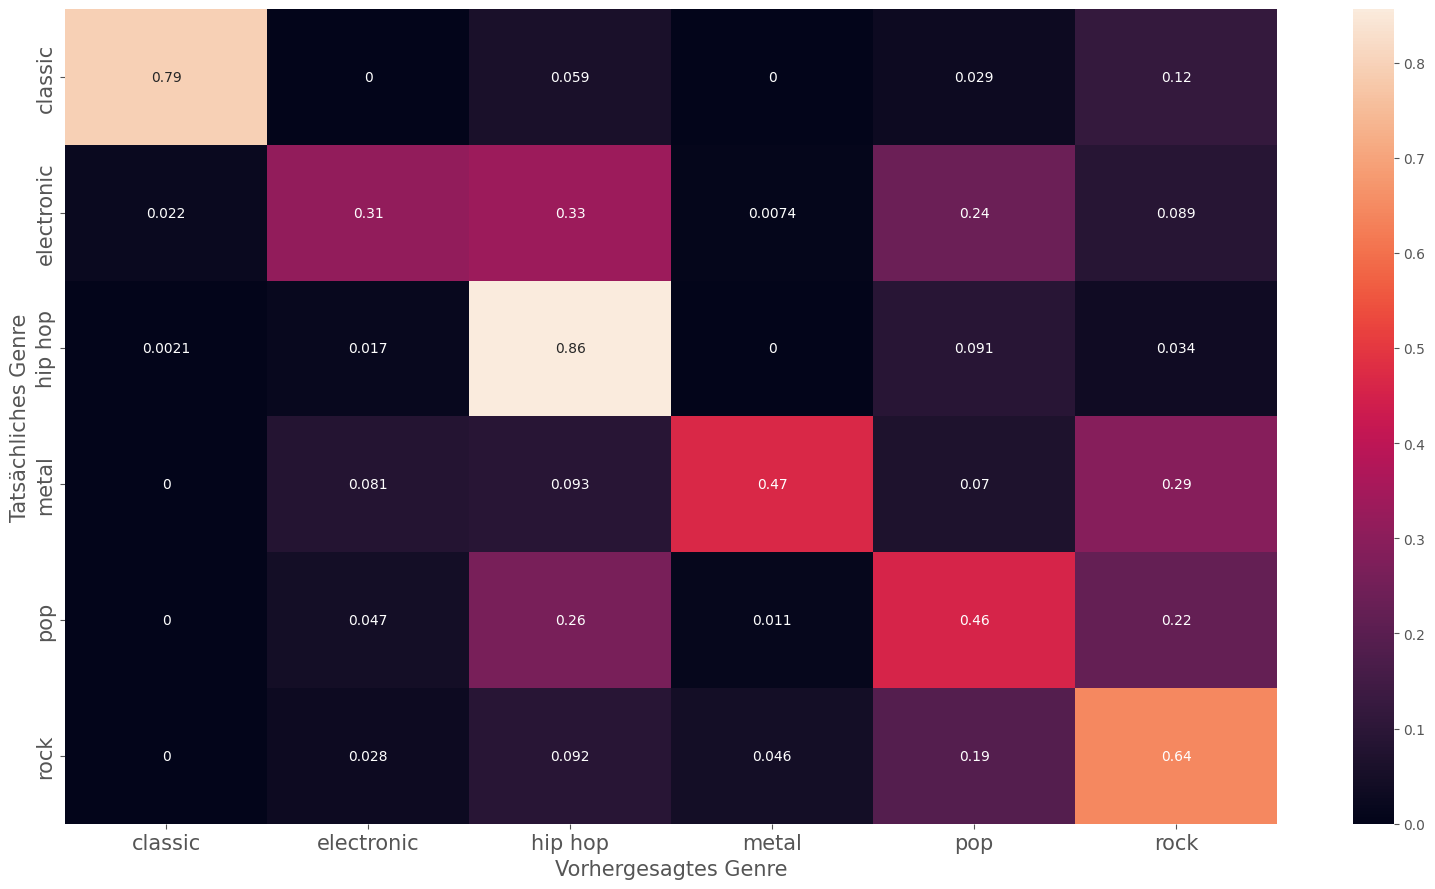

In [77]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(16, 9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.xlabel("Vorhergesagtes Genre", fontsize=15)
plt.ylabel("Tatsächliches Genre", fontsize=15)
plt.tick_params(axis="both", which="major", labelsize=15)
plt.tight_layout()
plt.savefig("../figures/svm/confusion_matrix_svm.png")

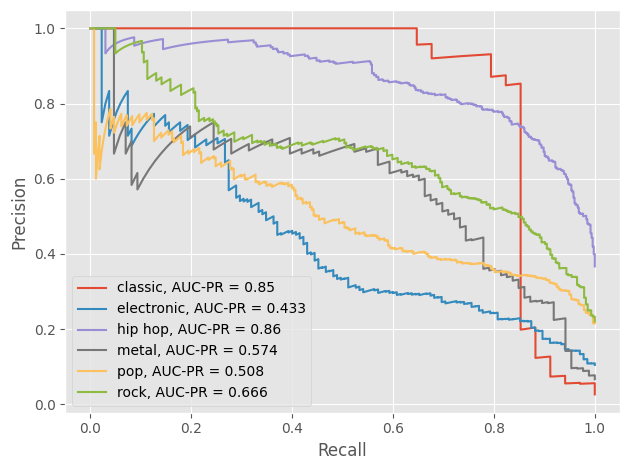

In [78]:
from sklearn.preprocessing import label_binarize
plt.figure()
plt.style.use('ggplot')

# Binarize y_test
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

# Get probability predictions
y_pred_proba = clf.predict_proba(X_test)

# Initialize list for AUC-PR values
auc_pr_values = []

# Get genre labels from the encoder
label = genre_encoder.classes_

# For each class
num_classes = 6
for i in range(num_classes):
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])

    # Compute AUC-PR
    auc_pr = auc(recall, precision)
    
    # Append AUC-PR value to the list
    auc_pr_values.append((label[i], auc_pr))

    # Plot Precision-Recall curve
    plt.plot(recall, precision, label=f"{label[i]}, AUC-PR = {auc_pr:.3}")

# Set labels and legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("../figures/svm/PR_SVM.pdf")

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83        34
           1       0.54      0.31      0.39       135
           2       0.72      0.86      0.78       473
           3       0.70      0.47      0.56        86
           4       0.48      0.46      0.47       278
           5       0.61      0.64      0.62       284

    accuracy                           0.64      1290
   macro avg       0.65      0.59      0.61      1290
weighted avg       0.63      0.64      0.63      1290



## kNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=12)
kn.fit(X_train, y_train)
y_pred = kn.predict(X_test)

In [81]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy on test set is {accuracy*100:.2f}%")

Model accuracy on test set is 60.62%


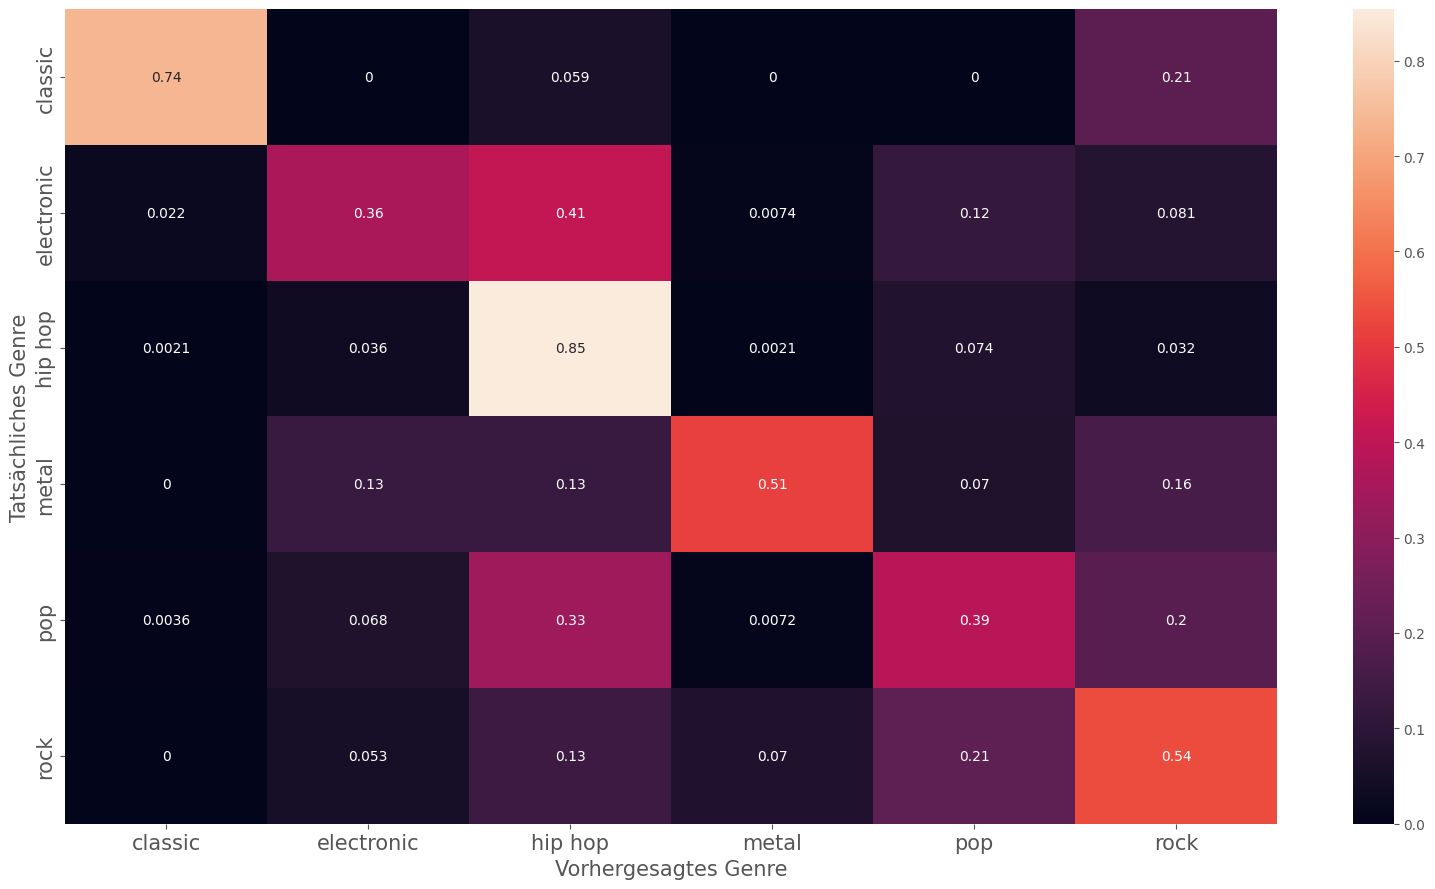

In [82]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(16, 9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.xlabel("Vorhergesagtes Genre", fontsize=15)
plt.ylabel("Tatsächliches Genre", fontsize=15)
plt.tick_params(axis="both", which="major", labelsize=15)
plt.tight_layout()
plt.savefig("../figures/knn/confusion_matrix_knn.png")

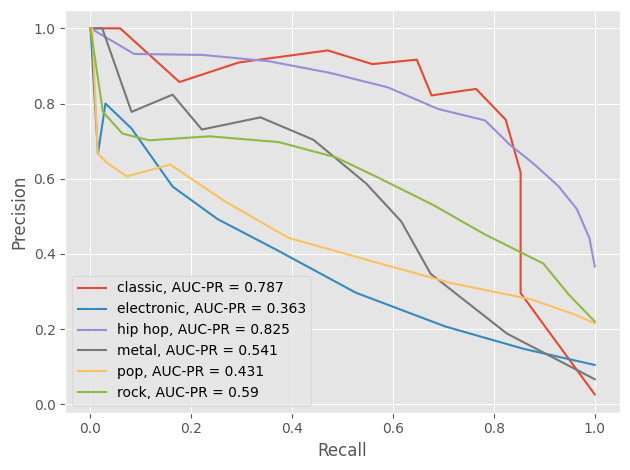

In [83]:
# Binarize y_test
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

# Get probability predictions
y_pred_proba = kn.predict_proba(X_test)

# Initialize list for AUC-PR values
auc_pr_values = []

# Get genre labels from the encoder
label = genre_encoder.classes_

# For each class
num_classes = 6
for i in range(num_classes):
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])

    # Compute AUC-PR
    auc_pr = auc(recall, precision)
    
    # Append AUC-PR value to the list
    auc_pr_values.append((label[i], auc_pr))

    # Plot Precision-Recall curve
    plt.plot(recall, precision, label=f"{label[i]}, AUC-PR = {auc_pr:.3}")

# Set labels and legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("../figures/knn/PR_KNN.pdf")


In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78        34
           1       0.44      0.36      0.40       135
           2       0.67      0.85      0.75       473
           3       0.65      0.51      0.57        86
           4       0.48      0.39      0.43       278
           5       0.60      0.54      0.57       284

    accuracy                           0.61      1290
   macro avg       0.61      0.56      0.58      1290
weighted avg       0.59      0.61      0.59      1290

